## Install Module

In [ ]:
pip install tensorflow

## Import Library

In [1]:
# --- Libraries yang digunakan ---
import os
import pathlib
import random
import shutil
import zipfile

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq
from google.colab import files, drive

# --- Mengimpor libraries untuk visualisasi ---
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# --- Mengimpor libraries untuk pemrosesan data gambar ---
from PIL import Image
import tensorflow as tf
from sklearn.model_selection import train_test_split
from collections import Counter

# --- Mengabaikan peringatan ---
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Data Loading

In [2]:
# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
# Path ke folder dataset di Google Drive
drive_path = '/content/drive/MyDrive/'
project_folder = 'parkinson'
dataset_path = os.path.join(drive_path, project_folder)
zip_file_name = 'parkinson_dataset.zip'
zip_file_path = os.path.join(dataset_path, zip_file_name)

In [9]:
# Direktori tujuan untuk mengesktrak isi zip
extraction_path = dataset_path

print(f"Mencoba mengekstrak: '{zip_file_path}' ke '{extraction_path}'")

if os.path.exists(zip_file_path):
    !unzip '{zip_file_path}' -d '{extraction_path}'
    print(f"\nFile '{zip_file_name}' berhasil diesktrak ke: {extraction_path}")
else:
    print(f"File '{zip_file_name}' tidak ditemukan di: {zip_file_path}")

Mencoba mengekstrak: '/content/drive/MyDrive/parkinson/parkinson_dataset.zip' ke '/content/drive/MyDrive/parkinson'
Archive:  /content/drive/MyDrive/parkinson/parkinson_dataset.zip
   creating: /content/drive/MyDrive/parkinson/parkinson_dataset/
   creating: /content/drive/MyDrive/parkinson/parkinson_dataset/meander/
   creating: /content/drive/MyDrive/parkinson/parkinson_dataset/meander/healthy/
  inflating: /content/drive/MyDrive/parkinson/parkinson_dataset/meander/healthy/meander_healthy_001.jpg  
  inflating: /content/drive/MyDrive/parkinson/parkinson_dataset/meander/healthy/meander_healthy_002.jpg  
  inflating: /content/drive/MyDrive/parkinson/parkinson_dataset/meander/healthy/meander_healthy_003.jpg  
  inflating: /content/drive/MyDrive/parkinson/parkinson_dataset/meander/healthy/meander_healthy_004.jpg  
  inflating: /content/drive/MyDrive/parkinson/parkinson_dataset/meander/healthy/meander_healthy_005.jpg  
  inflating: /content/drive/MyDrive/parkinson/parkinson_dataset/meande

## Exploratory Data Analysis

Pada tahapan ini dilakukan untuk memahami isi dan kualitas dataset sebelum diproses.

### Sampel Gambar untuk Semua Kelas

Untuk memahami seperti apa variasi visual dari tiap kelas  (healthy vs parkinson) dalam jenis gambar (spiral, wave, meander).

In [4]:
dataset_dir = '/content/drive/MyDrive/parkinson/parkinson_dataset/'
num_samples = 5  # Jumlah gambar yang ingin ditampilkan per kelas

sub_folders = ['meander', 'spiral', 'wave']
categories = ['healthy', 'parkinson']
all_data = {}

for sub_folder in sub_folders:
    for category in categories:
        folder_path = os.path.join(dataset_dir, sub_folder, category)
        if os.path.exists(folder_path) and os.path.isdir(folder_path):
            image_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
            if image_files:
                key_name = f"{category} ({sub_folder})"
                all_data[key_name] = image_files
            else:
                print(f"Tidak ada gambar ditemukan di: {folder_path}")
        else:
            print(f"Folder tidak ditemukan: {folder_path}")

num_rows = len(all_data)
if num_rows > 0:
    fig, axs = plt.subplots(num_rows, num_samples, figsize=(15, 3 * num_rows))
    if num_rows == 1:
        axs = [axs]  # Handle kasus hanya satu baris

    for i, (class_name_with_folder, image_list) in enumerate(all_data.items()):
        images = np.random.choice(image_list, min(num_samples, len(image_list)), replace=False)
        class_name = class_name_with_folder.split(' ')[0]
        folder_name = class_name_with_folder.split('(')[1][:-1]
        for j, image_name in enumerate(images):
            img_path = os.path.join(dataset_dir, folder_name, class_name, image_name)
            try:
                img = Image.open(img_path).convert("RGB")
                axs[i, j].imshow(img)
                axs[i, j].set(xlabel=class_name_with_folder, xticks=[], yticks=[])
            except FileNotFoundError:
                print(f"File tidak ditemukan: {img_path}")
                axs[i, j].set_title("File Not Found")
            except Exception as e:
                print(f"Gagal membuka gambar: {img_path} - {e}")
                axs[i, j].set_title("Error")

    fig.tight_layout()
    plt.show()
else:
    print("Tidak ada data gambar yang ditemukan.")

Output hidden; open in https://colab.research.google.com to view.

### Distribusi Gambar di Semua Kelas

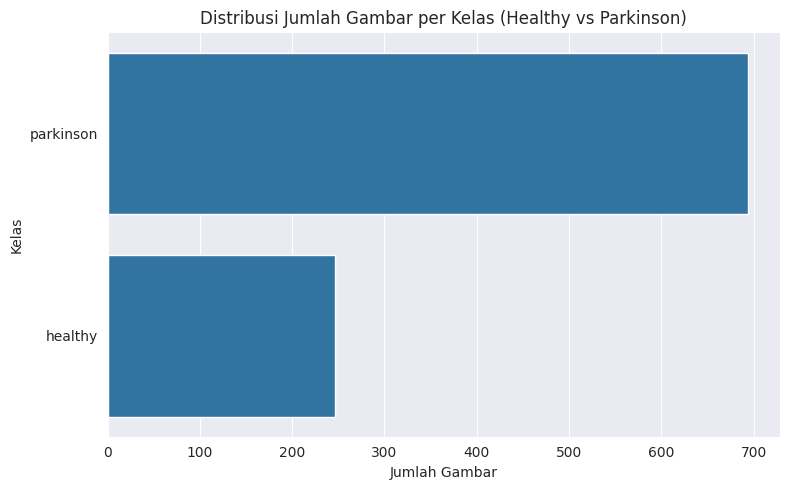


Jumlah Gambar per Kelas (Healthy vs Parkinson):
labels
parkinson    694
healthy      246
Name: count, dtype: int64


In [5]:
file_name = []
labels = []
full_path = []

# Mengumpulkan nama file, path lengkap, dan label dari setiap gambar
for path, subdirs, files in os.walk(dataset_dir):
    for name in files:
        if name.lower().endswith(('.png', '.jpg', '.jpeg')):  # Hanya memproses file gambar
            full_path.append(os.path.join(path, name))
            labels.append(path.split('/')[-1])
            file_name.append(name)

# Membuat DataFrame dari data yang terkumpul
distribution = pd.DataFrame({"path": full_path, 'file_name': file_name, "labels": labels})

# Filter DataFrame hanya untuk label 'healthy' dan 'parkinson'
distribution_filtered = distribution[distribution['labels'].isin(['healthy', 'parkinson'])]

# Menghitung jumlah gambar per kelas
label_counts = distribution_filtered['labels'].value_counts().sort_values(ascending=False)

# Plot distribusi untuk kelas 'healthy' dan 'parkinson'
plt.figure(figsize=(8, 5))
sns.set_style("darkgrid")
sns.countplot(y='labels', data=distribution_filtered, order=label_counts.index)
plt.title('Distribusi Jumlah Gambar per Kelas (Healthy vs Parkinson)')
plt.xlabel('Jumlah Gambar')
plt.ylabel('Kelas')
plt.tight_layout()
plt.show()

print("\nJumlah Gambar per Kelas (Healthy vs Parkinson):")
print(label_counts)

### Distribusi Gambar per Kelas dan Jenis

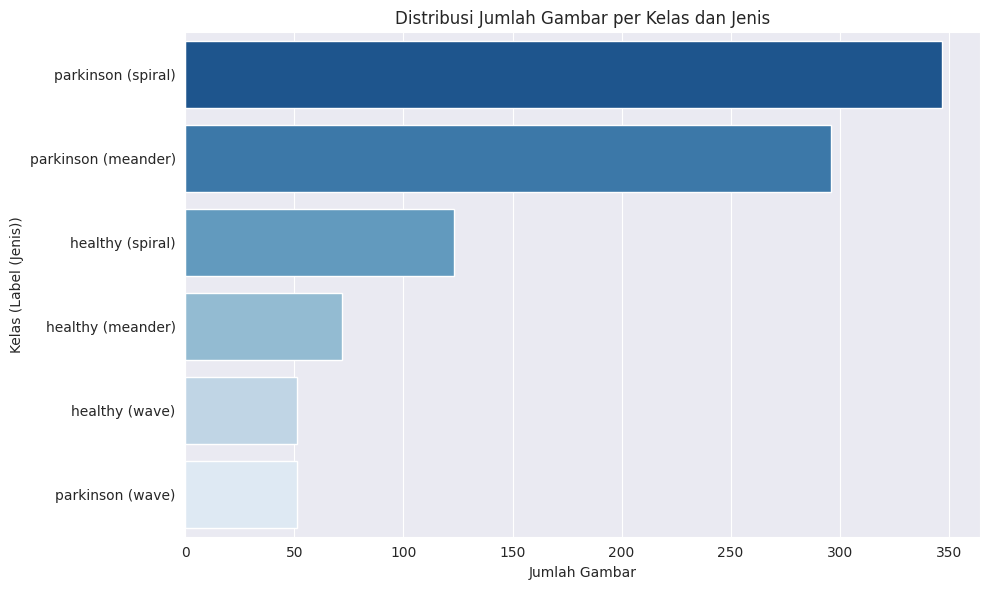


Jumlah Gambar per Kelas dan Jenis:
labels
parkinson (spiral)     347
parkinson (meander)    296
healthy (spiral)       123
healthy (meander)       72
healthy (wave)          51
parkinson (wave)        51
Name: count, dtype: int64


In [6]:
full_path = []
combined_labels = []

# Mengumpulkan path dan label yang dikombinasikan
for path, subdirs, files in os.walk(dataset_dir):
    if path.endswith('healthy') or path.endswith('parkinson'):
        image_type = path.split('/')[-2]
        current_label = path.split('/')[-1]
        for name in files:
            if name.lower().endswith(('.png', '.jpg', '.jpeg')):
                full_path.append(os.path.join(path, name))
                combined_labels.append(f"{current_label} ({image_type})")

# Membuat DataFrame
distribution = pd.DataFrame({"path": full_path, "labels": combined_labels})

# Menghitung jumlah gambar per kelas dan jenis
label_counts = distribution['labels'].value_counts().sort_values(ascending=False)

# Plot distribusi
plt.figure(figsize=(10, 6))
n_labels = len(label_counts)
palette = sns.color_palette("Blues_r", n_labels)
sns.set_style("darkgrid")
sns.countplot(y='labels', data=distribution, order=label_counts.index, palette=palette)
plt.title('Distribusi Jumlah Gambar per Kelas dan Jenis')
plt.xlabel('Jumlah Gambar')
plt.ylabel('Kelas (Label (Jenis))')
plt.tight_layout()
plt.show()

print("\nJumlah Gambar per Kelas dan Jenis:")
print(label_counts)

Visualisasi di atas menunjukkan distribusi jumlah gambar untuk setiap kombinasi kelas (healthy, parkinson) dan jenis gambar (meander, spiral, wave) dalam dataset.

**Observasi:**

* Kelas **parkinson** secara umum memiliki jumlah gambar yang lebih banyak dibandingkan kelas **healthy**.
* Jenis gambar **spiral** memiliki jumlah sampel terbanyak, terutama untuk kelas **parkinson**.
* Jenis gambar **wave** memiliki jumlah sampel yang paling sedikit untuk kedua kelas.
* Terlihat adanya ketidakseimbangan data antar kelas dan jenis. Misalnya, jumlah gambar **parkinson (spiral)** jauh lebih banyak dibandingkan **healthy (wave)** atau **parkinson (wave)**.

**Implikasi:**

Ketidakseimbangan distribusi ini dapat mempengaruhi kinerja model klasifikasi yang akan dilatih menggunakan dataset ini. Model berpotensi menjadi bias terhadap kelas dan jenis dengan jumlah sampel yang lebih banyak.

**Langkah Selanjutnya:**

Untuk mengatasi ketidakseimbangan ini, beberapa teknik dapat dipertimbangkan selama tahap *preprocessing* dan pelatihan model, seperti *oversampling* kelas minoritas, *undersampling* kelas mayoritas, atau penggunaan teknik augmentasi data.

## Preprocessing Dataset

### Mengecek Format Warna dan Channel RGB

In [7]:
# Cek RGB channel
rgb_channels = []
for path in distribution_filtered['path']:
    try:
        img = Image.open(path)
        rgb_channels.append(len(img.getbands()))
    except:
        pass
print(Counter(rgb_channels))

Counter({3: 931, 4: 9})


**Insight**

* 931 gambar yang memiliki 3 channel warna (yang biasanya berwarna RGB).
* 9 gambar yang memiliki 4 channel warna (yang biasanya berarti gambar berwarna RGBA, di mana 'A' adalah alpha atau transparansi).

**Implikasinya untuk pemrosesan gambar:**

Sebagian besar gambar adalah gambar berwarna standar (RGB).
Ada sebagian kecil gambar (9 dari total) yang memiliki saluran alpha.
Langkah selanjutnya yang mungkin perlu dipertimbangkan:

**Langkah selanjutnya:**
Karena pada model machine learning untuk gambar harus memiliki channel warna yang konsisten, maka akan dilakukan konversi semua gambar ke format RGB.

In [8]:
# Konversi RGBA ke RGB
for path, subdirs, files in os.walk(dataset_dir):
    if path.endswith('healthy') or path.endswith('parkinson'):
        image_type = path.split('/')[-2]
        current_label = path.split('/')[-1]
        for name in files:
            if name.lower().endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(path, name)
                try:
                    img = Image.open(img_path).convert('RGB')  # Konversi ke RGB saat dibuka
                    full_path.append(img_path)
                    combined_labels.append(f"{current_label} ({image_type})")
                except Exception as e:
                    print(f"Gagal membuka atau mengonversi {img_path}: {e}")

print(f"Panjang full_path setelah pemuatan: {len(full_path)}")
print(f"Panjang combined_labels setelah pemuatan: {len(combined_labels)}")

Panjang full_path setelah pemuatan: 1880
Panjang combined_labels setelah pemuatan: 1880



DataFrame berhasil dibuat.


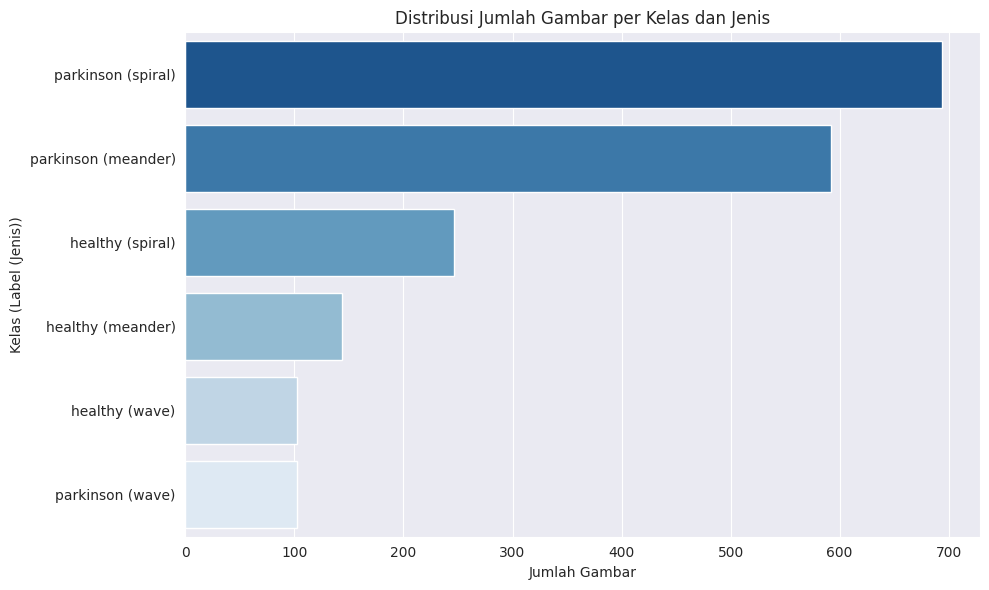


Jumlah Gambar per Kelas dan Jenis:
labels
parkinson (spiral)     694
parkinson (meander)    592
healthy (spiral)       246
healthy (meander)      144
healthy (wave)         102
parkinson (wave)       102
Name: count, dtype: int64


In [9]:
# Membuat DataFrame
if len(full_path) == len(combined_labels):
    distribution = pd.DataFrame({"path": full_path, "labels": combined_labels})
    print("\nDataFrame berhasil dibuat.")

    label_counts = distribution['labels'].value_counts().sort_values(ascending=False)

    plt.figure(figsize=(10, 6))
    n_labels = len(label_counts)
    palette = sns.color_palette("Blues_r", n_labels)
    sns.set_style("darkgrid")
    sns.countplot(y='labels', data=distribution, order=label_counts.index, palette=palette)
    plt.title('Distribusi Jumlah Gambar per Kelas dan Jenis')
    plt.xlabel('Jumlah Gambar')
    plt.ylabel('Kelas (Label (Jenis))')
    plt.tight_layout()
    plt.show()

    print("\nJumlah Gambar per Kelas dan Jenis:")
    print(label_counts)

else:
    print("\nPanjang full_path dan combined_labels tidak sama. Tidak dapat membuat DataFrame.")
    print("Periksa kembali proses pemuatan data.")

### Mengecek Ukuran Gambar

In [10]:
image_sizes = {}

for sub_folder in sub_folders:
    for category in categories:
        folder_path = os.path.join(dataset_dir, sub_folder, category)
        if os.path.exists(folder_path) and os.path.isdir(folder_path):
            for filename in os.listdir(folder_path):
                if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                    img_path = os.path.join(folder_path, filename)
                    try:
                        with Image.open(img_path) as img:
                            size = img.size
                            if (sub_folder, category) not in image_sizes:
                                image_sizes[(sub_folder, category)] = []
                            image_sizes[(sub_folder, category)].append(size)
                    except Exception as e:
                        print(f"Gagal membuka {img_path}: {e}")

for key, sizes in image_sizes.items():
    print(f"Ukuran gambar untuk {key}: {set(sizes)}")

Ukuran gambar untuk ('meander', 'healthy'): {(570, 570), (558, 544), (560, 541), (566, 566), (571, 556), (576, 540), (588, 566), (580, 562), (534, 540), (561, 530), (586, 544), (564, 520), (587, 552), (552, 524), (576, 552), (556, 528), (578, 552), (558, 522), (560, 528), (548, 526), (546, 538), (560, 534), (554, 530), (588, 556), (552, 532), (604, 546), (574, 560), (595, 601), (600, 530), (598, 572), (551, 528), (557, 568), (566, 580), (552, 526), (564, 528), (586, 558), (580, 576), (566, 522), (595, 564), (548, 516), (556, 582), (570, 550), (545, 557), (564, 540), (592, 556), (576, 560), (548, 522), (548, 528), (570, 568), (602, 542), (582, 542), (554, 584), (544, 555), (557, 552), (562, 536), (550, 513), (566, 570), (564, 576), (550, 522), (571, 563), (532, 547), (562, 554), (540, 566), (550, 540), (557, 521), (606, 542), (552, 534), (556, 547), (560, 538), (588, 554)}
Ukuran gambar untuk ('meander', 'parkinson'): {(604, 544), (570, 576), (632, 560), (604, 608), (571, 550), (560, 55

Pada tahapan ini, kita melihat jenis ukuran dan label dalam dataset. Jika setnya hanya berisi satu ukuran, berarti semua gambar dalam kategori tersebut memiliki ukuran yang sama.

Dari hasil di atas, diketahui:
- Untuk jenis gambar meander, ukuran gambar sangat bervariasi baik untuk kelas healthy maupun parkinson.
- Untuk jenis gambar spiral, ukurannya juga cukup bervariasi, meskipun terlihat ada kecenderungan ukuran yang lebih besar dibandingkan meander.
- Untuk jenis gambar wave, lebar gambar konsisten (512 piksel), tetapi tinggi gambar sangat bervariasi.

Dataset ini memiliki gambar dengan ukuran yang tidak seragam. Ini adalah informasi penting untuk langkah selanjutnya, seperti mempersiapkan data untuk model deep learning, di mana seringkali input dengan ukuran yang sama diperlukan. Kita mungkin perlu melakukan resizing atau cropping pada gambar.

### Mengecek Ukuran dan Format File

In [11]:
sample_image_path = distribution_filtered['path'].sample(5).tolist()

for img_path in sample_image_path:
    with Image.open(img_path) as img:
        print(f"{os.path.basename(img_path)} - Size: {img.size}, Mode: {img.mode}")

wave_parkinson_049.jpg - Size: (512, 234), Mode: RGB
wave_parkinson_045.jpg - Size: (512, 393), Mode: RGB
meander_parkinson_141.jpg - Size: (559, 542), Mode: RGB
meander_parkinson_144.jpg - Size: (567, 558), Mode: RGB
meander_parkinson_179.jpg - Size: (568, 552), Mode: RGB


### Mengecek Gambar Corrupt

In [12]:
corrupt_paths = []
for path in distribution_filtered['path']:
    try:
        img = Image.open(path)
        img.verify()
    except:
        corrupt_paths.append(path)
print(f"Jumlah gambar corrupt: {len(corrupt_paths)}")

Jumlah gambar corrupt: 0


### Normalisasi Label

Pada tahapan ini, kita akan menormalisasikan label menjadi hanya `parkinson` dan `healthy` supaya model fokus dalam klasifikasikan kondisi pasien, bukan jenis gambarnya, dan juga membantu balancing data antar kelas.

In [13]:
# Ubah label menjadi 2 kelas utama: 'parkinson' dan 'healthy'
distribution_filtered['labels'] = distribution_filtered['labels'].apply(
    lambda x: 'parkinson' if 'parkinson' in x.lower() else 'healthy'
)

### Split Data

Pada tahapan ini dilakukan untuk menjaga proporsi antar kelas agar tetap seimbang, langkah ini sangat penting untuk model agar tidak bias ke kelas mayoritas.

In [14]:
SEED = 42

# Split data: test (10%), train (80%), val (10%) dari sisa
test_df = distribution_filtered.groupby('labels', group_keys=False).apply(lambda x: x.sample(frac=0.1, random_state=SEED))
trainval_df = distribution_filtered.drop(test_df.index)
train_df, val_df = train_test_split(trainval_df, test_size=0.2, stratify=trainval_df['labels'], random_state=SEED)
print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

Train: 676, Val: 170, Test: 94


<ipython-input-14-33cc65c5475a>:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  test_df = distribution_filtered.groupby('labels', group_keys=False).apply(lambda x: x.sample(frac=0.1, random_state=SEED))


### Salin Gambar ke Folder sesuai Split dan Label

In [19]:
def copy_images_to_split_folder(df, split_name, base_path='/content/drive/MyDrive/parkinson/split_data'):
    for _, row in tq(df.iterrows(), total=len(df)):
        label = row['labels']
        dst_dir = os.path.join(base_path, split_name, label)
        os.makedirs(dst_dir, exist_ok=True)
        shutil.copy(row['path'], os.path.join(dst_dir, os.path.basename(row['path'])))

copy_images_to_split_folder(train_df, "train")
copy_images_to_split_folder(val_df, "val")
copy_images_to_split_folder(test_df, "test")

  0%|          | 0/676 [00:00<?, ?it/s]

  0%|          | 0/170 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

### Load Dataset

In [20]:
IMG_SIZE = (224, 224) # untuk menyesuaikan size gambar
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

train_ds = tf.keras.utils.image_dataset_from_directory(
    '/content/drive/MyDrive/parkinson/split_data/train',
    labels='inferred',
    label_mode='int',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    '/content/drive/MyDrive/parkinson/split_data/val',
    labels='inferred',
    label_mode='int',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    '/content/drive/MyDrive/parkinson/split_data/test',
    labels='inferred',
    label_mode='int',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED
)

Found 676 files belonging to 2 classes.
Found 170 files belonging to 2 classes.
Found 94 files belonging to 2 classes.


## Augmentasi Data

Pada tahapan ini dilakukan untuk mencegah overfitting & membantu minoritas kelas dengan variasi tambahan. tapi hanya diterapkan di train set, bukan val/test.

In [21]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),          # Normalisasi 0–1
    tf.keras.layers.RandomFlip("horizontal"),   # Flip kiri-kanan
    tf.keras.layers.RandomRotation(0.15),       # Rotasi ±15%
    tf.keras.layers.RandomZoom(0.1),            # Zoom ±10%
    tf.keras.layers.RandomContrast(0.1),        # Kontras ±10%
])

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)

val_ds = val_ds.map(lambda x, y: (x / 255.0, y)).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.map(lambda x, y: (x / 255.0, y)).prefetch(buffer_size=AUTOTUNE)

In [22]:
for images, labels in train_ds.take(1):
    print(f"Image batch shape: {images.shape}")
    print(f"Label batch shape: {labels.shape}")

Image batch shape: (32, 224, 224, 3)
Label batch shape: (32,)
